# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

1. Download the dataset
2. Upload to Drive
3. Import from drive to colab
4. Load the images and create training data.
5. Build U-net Model
6. Train your model.
7. Check the validation accuracy and plot sample.

In [114]:
#Importing necessary libraries
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from PIL import Image

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### 1.Set your project path where you have your data and related files for this lab.

In [115]:
project_path = "C:/Users/Aadee/Desktop/PythonCoding/AdvancedComputerVision/tgs-salt-identification-challenge"

### 2. Set the necessary parameters

## Setup

In [116]:
im_height = 224
im_width = 224

mask_cell_height = 28
mask_cell_width = 28



# 3. Make directory for train data at in your project/lab folder.

Hint - use !mkdir function.

In [117]:
os.mkdir(project_path +'/train')

# 4. Extract your train images to the train directory you have just created above. 
train.zip and test.zip files available at your google drive/local system.

As a good practice - Upload or copy the data at your project path folder.

Make sure you are providing the right project_path.

In [118]:
from zipfile import ZipFile
with ZipFile(project_path + '/train.zip', 'r') as zf:
    zf.extractall(project_path +'/train')

# both images & masks are extracted at train folder under project path 

### 5. Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [119]:
images_list = os.listdir(project_path +'/train'+'/images')
masks_list = os.listdir(project_path +'/train'+'/masks')
print("number of images: ",len(images_list))
print("number of masks: ",len(masks_list))
#print("shape of image:", len(images_list[0]))
#print("shape of mask:", masks_list[0].shape)

number of images:  4000
number of masks:  4000


In [120]:
num = 1000 ### Restricting the images to 1000.
images_list = images_list[:num]
masks_list = masks_list[:num]
print("number of images: ",len(images_list))
print("number of masks: ",len(masks_list))

number of images:  1000
number of masks:  1000


In [121]:
# printing some of the names as given below.
print(images_list[-1])
print(masks_list[-1])
print(images_list[100])
print(masks_list[100])

428a877104.png
428a877104.png
07cbc65347.png
07cbc65347.png


# 6. Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


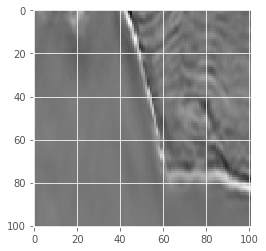

In [122]:
plt.imshow(cv2.imread(project_path +'/train'+'/images/'+images_list[10]))

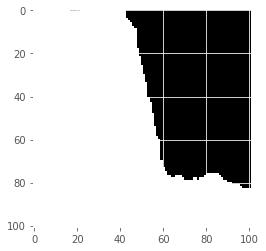

In [123]:
plt.imshow(cv2.imread(project_path +'/train'+'/masks/'+masks_list[10]))

# 7. Create your training data.

Hints - 

image_path = os.path.join(project_path +'path of your image directory' +n )

mask_path = os.path.join(project_path +'path of your mask directory'+n )

In [124]:
#Get the data -  X and y
y = np.zeros((len(masks_list), mask_cell_height, mask_cell_width), dtype=np.float32)
X = np.zeros((len(images_list), im_height, im_width, 1), dtype=np.float32)

for file in images_list:
    n = images_list.index(file)
    imagepath = os.path.join(project_path +'/train'+'/images/', file)
    #print(imagepath)
    img = Image.open(imagepath)
    img = img.resize((im_width, im_height))
    img = np.reshape(img.convert('L'), (224,224,1)) ## Converting the image to greyscale
    X[n] = img
    #X[n] =  X[n]/255
    file2 = masks_list[n]
    maskspath = os.path.join(project_path +'/train'+'/masks/', file2)
    #print(maskspath)
    # Load masks
    mask = cv2.imread(maskspath)
    mask = (mask!=2)*1.0  
    mask = cv2.resize(mask, (28, 28))
    mask = 1.0*(mask[:,:,0]>0.2)
    y[n] = mask
    #y[n] = y[n]/255
    #print("...........",y[n])
print(X[0])
print(y[0])

[[[131.]
  [131.]
  [131.]
  ...
  [100.]
  [105.]
  [105.]]

 [[131.]
  [131.]
  [131.]
  ...
  [100.]
  [105.]
  [105.]]

 [[131.]
  [131.]
  [131.]
  ...
  [ 89.]
  [ 95.]
  [ 95.]]

 ...

 [[144.]
  [144.]
  [141.]
  ...
  [116.]
  [113.]
  [113.]]

 [[146.]
  [146.]
  [137.]
  ...
  [139.]
  [139.]
  [139.]]

 [[146.]
  [146.]
  [137.]
  ...
  [139.]
  [139.]
  [139.]]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]

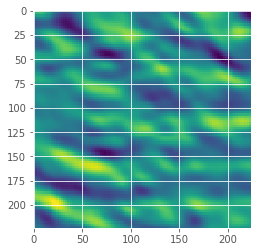

In [139]:
#Check the images
plt.imshow(X[1].squeeze())

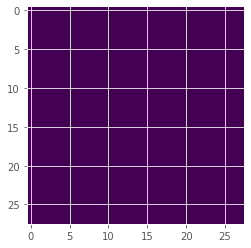

In [140]:
plt.imshow(y[1])

In [125]:
# Split train and valid

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2019)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


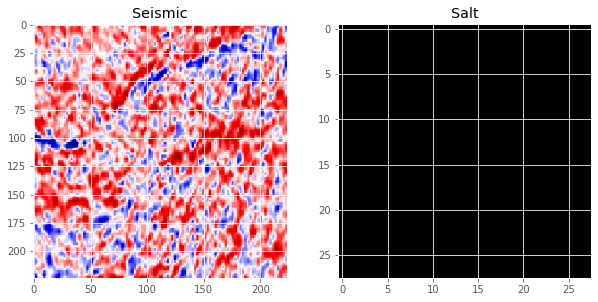

In [126]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');




### 8. Define loss and dice_coeff function.

In [127]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [128]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### 9. Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [129]:
#Install segmentation models
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to c:\users\aadee\appdata\local\temp\pip-req-build-d_tbxb8g
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33859 sha256=260b3155c85da26bc0543b3cdfdad3b39f7ebcb7b2588b1afa77b38c46aff4cf
  Stored in directory: C:\Users\Aadee\AppData\Local\Temp\pip-ephem-wheel-cache-fnz19_0y\wheels\02\cd\18\61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Running command git clone -q https://github.com/qubvel/segmentation_models 'C:\Users\Aadee\AppData\Local\Temp\pip-req-build-d_tbxb8g'
  Running command git submodule update --init --recursive -q


In [130]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [131]:
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)

In [132]:
x_val.shape

(150, 224, 224, 1)

In [133]:
x_train.shape

(850, 224, 224, 1)

In [134]:
y_train.shape

(850, 28, 28)

In [135]:
y_valid.shape

(150, 28, 28)

In [136]:
#model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))
#compile your model by adding the parameters like optimizer, loss and metrics.

#Build your model 
from keras.layers import Reshape
N = x_train.shape[-1]
print(N)
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(224, 224, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)
x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(out)
x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(x)
x = Conv2D(1, kernel_size=2,strides=2, activation="sigmoid")(x)
x = Reshape((mask_cell_height, mask_cell_width))(x)

model = Model(inp, x, name=base_model.name)
model.summary()

1
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 3)       6         
_________________________________________________________________
model_10 (Model)             multiple                  24456154  
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 1)       5         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 56, 56, 1)         5         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 1)         5         
_________________________________________________________________
reshape_5 (Reshape)          (None, 28, 28)            0

### 10. Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [137]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
# compile model
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [138]:
model.fit(
    x=x_train,
    y=y_train,
    batch_size=50,    
    epochs=2,
    validation_data=(x_val, y_valid)
)

Train on 850 samples, validate on 150 samples
Epoch 1/2
850/850 [==============================] - ETA: 41:17 - loss: 0.9872 - dice_coefficient: 0.696 - ETA: 37:00 - loss: 0.9852 - dice_coefficient: 0.697 - ETA: 32:46 - loss: 0.9828 - dice_coefficient: 0.698 - ETA: 29:35 - loss: 0.9801 - dice_coefficient: 0.698 - ETA: 27:02 - loss: 0.9775 - dice_coefficient: 0.699 - ETA: 24:35 - loss: 0.9748 - dice_coefficient: 0.700 - ETA: 22:24 - loss: 0.9719 - dice_coefficient: 0.701 - ETA: 20:04 - loss: 0.9687 - dice_coefficient: 0.702 - ETA: 17:41 - loss: 0.9652 - dice_coefficient: 0.702 - ETA: 15:21 - loss: 0.9614 - dice_coefficient: 0.704 - ETA: 13:06 - loss: 0.9575 - dice_coefficient: 0.705 - ETA: 10:57 - loss: 0.9536 - dice_coefficient: 0.706 - ETA: 8:44 - loss: 0.9500 - dice_coefficient: 0.707 - ETA: 6:32 - loss: 0.9466 - dice_coefficient: 0.70 - ETA: 4:19 - loss: 0.9433 - dice_coefficient: 0.70 - ETA: 2:49 - loss: 0.9403 - dice_coefficient: 0.70 - 2880s 3s/step - loss: 0.9374 - dice_coeffici

### 11.Predict on val set using model.predict funtion and store in preds_val variable.



In [147]:
Loss, dice_coefficient = model.evaluate(x_val, y_valid, verbose=1)  # Model evaluation
print("Loss:",Loss,"dice_coefficient:",dice_coefficient)

150/150 [==============================] - ETA: 46 - ETA: 37 - ETA: 24 - ETA: 10 - 69s 463ms/step
Loss: 0.9085159230232239 dice_coefficient: 0.7187422513961792


In [148]:
#predict on val
preds_val = model.predict(x_val, verbose=1)

150/150 [==============================] - ETA: 49 - ETA: 36 - ETA: 22 - ETA: 9 - 66s 439ms/step


In [143]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [144]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: No contour levels were found within the data range.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: No contour levels were found within the data range.


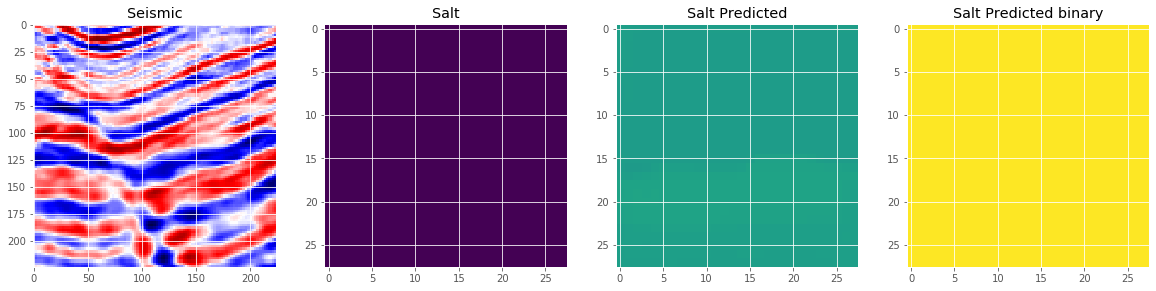

In [145]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.